In [1]:
import desitrip

In [2]:
from desispec.io import read_spectra
from desitrip.preproc import rescale_flux, rebin_flux

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.signal import medfilt

from astropy.table import Table, Column, vstack, join

mpl.rc('font', size=16)

In [4]:
import glob
from astropy.io import fits
from scipy.ndimage import median_filter
get_ipython().run_line_magic('matplotlib', 'inline')

In [7]:
import pickle
with open('z_host_fibermap.data', 'rb') as filehandle:
    # read the data as binary data stream
    z_host = pickle.load(filehandle)
    
with open('z_sn_fibermap.data', 'rb') as filehandle:
    # read the data as binary data stream
    z_sn = pickle.load(filehandle)

In [8]:
len(z_sn),len(z_host)

(10000, 10000)

In [9]:
def _unweighted_resample(output_x,input_x,input_flux_density, extrapolate=False) :
    # shorter names
    ix=input_x
    iy=input_flux_density
    ox=output_x

    # boundary of output bins
    bins=np.zeros(ox.size+1)
    bins[1:-1]=(ox[:-1]+ox[1:])/2.
    bins[0]=1.5*ox[0]-0.5*ox[1]     # = ox[0]-(ox[1]-ox[0])/2
    bins[-1]=1.5*ox[-1]-0.5*ox[-2]  # = ox[-1]+(ox[-1]-ox[-2])/2
    
    # make a temporary node array including input nodes and output bin bounds
    # first the boundaries of output bins
    tx=bins.copy()

    # if we do not extrapolate,
    # because the input is a considered a piece-wise linear function, i.e. the sum of triangles f_i(x),
    # we add two points at ixmin = ix[0]-(ix[1]-ix[0]) and  ixmax = ix[-1]+(ix[-1]-ix[-2])
    # with zero flux densities, corresponding to the edges of the first and last triangles.
    # this solves naturally the edge problem.
    if not extrapolate :
        # note we have to keep the array sorted here because we are going to use it for interpolation
        ix = np.append( 2*ix[0]-ix[1] , ix)
        iy = np.append(0.,iy)
        ix = np.append(ix, 2*ix[-1]-ix[-2])
        iy = np.append(iy, 0.)

    # this sets values left and right of input range to first and/or last input values
    # first and last values are=0 if we are not extrapolating
    ty=np.interp(tx,ix,iy)
    
    #  add input nodes which are inside the node array
    k=np.where((ix>=tx[0])&(ix<=tx[-1]))[0]
    if k.size :
        tx=np.append(tx,ix[k])
        ty=np.append(ty,iy[k])
        
    # sort this node array
    p = tx.argsort()
    tx=tx[p]
    ty=ty[p]
    
    # now we do a simple integration in each bin of the piece-wise
    # linear function of the temporary nodes

    # integral of individual trapezes
    trapeze_integrals=(ty[1:]+ty[:-1])*(tx[1:]-tx[:-1])/2.
    
    # output flux
    # for each bin, we sum the trapeze_integrals that belong to that bin
    # and divide by the bin size

    trapeze_centers=(tx[1:]+tx[:-1])/2.
    binsize = bins[1:]-bins[:-1]

    if np.any(binsize<=0)  :
        raise ValueError("Zero or negative bin size")
    
    return np.histogram(trapeze_centers, bins=bins, weights=trapeze_integrals)[0] / binsize

In [10]:
from desiutil.log import get_logger
from desispec.io import read_spectra

# Source: DESI Interpolation Project
def resample_flux(xout, x, flux, ivar=None, extrapolate=False):
    if ivar is None:
        return _unweighted_resample(xout, x, flux, extrapolate=extrapolate)
    else:
        if extrapolate :
            raise ValueError("Cannot extrapolate ivar. Either set ivar=None and extrapolate=True or the opposite")
        a = _unweighted_resample(xout, x, flux*ivar, extrapolate=False)
        b = _unweighted_resample(xout, x, ivar, extrapolate=False)
        mask = (b>0)
        outflux = np.zeros(a.shape)
        outflux[mask] = a[mask] / b[mask]
        dx = np.gradient(x)
        dxout = np.gradient(xout)
        outivar = _unweighted_resample(xout, x, ivar/dx)*dxout
        
        return outflux, outivar

In [12]:
snia_files = np.sort(glob.glob((r'/scratch/vtiwari2/DESI Transient Sims/sneia*/*coadd.fits')))
host_files = np.sort(glob.glob((r'/scratch/vtiwari2/DESI Transient Sims/host*/*coadd.fits')))

In [13]:
flux_sn = []
for f in snia_files:
        spectra = read_spectra(f)
        wave = spectra.wave['brz']
        flux = spectra.flux['brz']
        ivar = spectra.ivar['brz']
        flux_sn.append(flux)

In [14]:
flux_host = []
for f in host_files:
        spectra = read_spectra(f)
        wave = spectra.wave['brz']
        fluxs = spectra.flux['brz']
        ivar = spectra.ivar['brz']
        flux_host.append(fluxs)

In [17]:
for f in snia_files:
    h = fits.open(f)
    wave = h['BRZ_WAVELENGTH'].data

wave_sn=[]
for i in range (len(flux_sn)):
    z = z_sn[i]
    lambd = wave/(1+z)
    wave_sn.append(lambd)

wave_host = []
for i in range (len(flux_host)):
    z = z_host[i]
    lambd = wave/(1+z)
    wave_host.append(lambd)

In [18]:
len(wave_host),len(wave_sn),len(flux_sn)

(100, 100, 100)

In [19]:
len(wave),len(wave_sn[0]),len(flux_sn[0][99]),len(flux_host[0][99])

(6265, 6265, 6265, 6265)

In [20]:
def resample(f,wave_em):
    l = len(f)
    flux_em = []
    for j in range(100):
        for i in range(100):
            output = resample_flux(wave_em[i], wave, f[j][i], ivar=None, extrapolate=False)
            flux_em.append(output)
    return flux_em

In [21]:
flux_em_sn = resample(flux_sn,wave_sn)
flux_em_host = resample(flux_host,wave_host)

In [23]:
len(flux_em_sn),len(flux_em_host)

(10000, 10000)

In [24]:
def condition_spectra_sn(input_files,n):
    fluxes = None
    for i in range(len(input_files)):
        f = input_files[i]
        spectra = read_spectra(f)
        wave = spectra.wave['brz']
        x,y = int(100*i),int(100*(i+1))
        flux = flux_em_sn[x:y]
        ivar = spectra.ivar['brz']
        # Pre-condition: remove spectra with NaNs and zero flux values.
        mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
        mask_idx = np.argwhere(mask)
        flux = np.delete(flux, mask_idx, axis=0)
        ivar = np.delete(ivar, mask_idx, axis=0)
        
        # Pre-condition: remove spectra with NaNs and zero flux values.
        mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
        mask_idx = np.argwhere(mask)
        flux = np.delete(flux, mask_idx, axis=0)
        ivar = np.delete(ivar, mask_idx, axis=0)

        # Rebin and rescale fluxes so that each is normalized between 0 and 1.
        rewave, reflux, reivar = rebin_flux(wave, flux, ivar, minwave=3600., maxwave=9800., nbins=n, log=True)
        rsflux = rescale_flux(reflux)

        if fluxes is None:
            fluxes = rsflux
        else:
            fluxes = np.concatenate((fluxes, rsflux))
    return fluxes

In [26]:
snia_flux  = condition_spectra_sn(snia_files,150)

In [27]:
def condition_spectra_h(input_files,n):
    """Read DESI spectra, rebin to a subsampled logarithmic wavelength grid, and rescale.
    
    Parameters
    ----------
    input_files : list or ndarray
        List of FITS files on disk with DESI spectra.
    
    Returns
    -------
    fluxes : ndarray
        Array of fluxes rebinned to a logarithmic wavelength grid.
    """
    fluxes = None
    
    for i in range (len(input_files)):
        f = input_files[i]
        spectra = read_spectra(f)
        wave = spectra.wave['brz']
        x,y = int(100*i),int(100*(i+1))
        flux = flux_em_host[x:y]
        ivar = spectra.ivar['brz']

        # Pre-condition: remove spectra with NaNs and zero flux values.
        mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
        mask_idx = np.argwhere(mask)
        flux = np.delete(flux, mask_idx, axis=0)
        ivar = np.delete(ivar, mask_idx, axis=0)
        
        # Pre-condition: remove spectra with NaNs and zero flux values.
        mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
        mask_idx = np.argwhere(mask)
        flux = np.delete(flux, mask_idx, axis=0)
        ivar = np.delete(ivar, mask_idx, axis=0)

        # Rebin and rescale fluxes so that each is normalized between 0 and 1.
        rewave, reflux, reivar = rebin_flux(wave, flux, ivar, minwave=3600., maxwave=9800., nbins=n, log=True)
        rsflux = rescale_flux(reflux)

        if fluxes is None:
            fluxes = rsflux
        else:
            fluxes = np.concatenate((fluxes, rsflux))
    
    return fluxes

In [35]:
host_flux  = condition_spectra_h(host_files,150)

In [36]:
len(snia_flux),len(host_flux)

(9964, 9969)

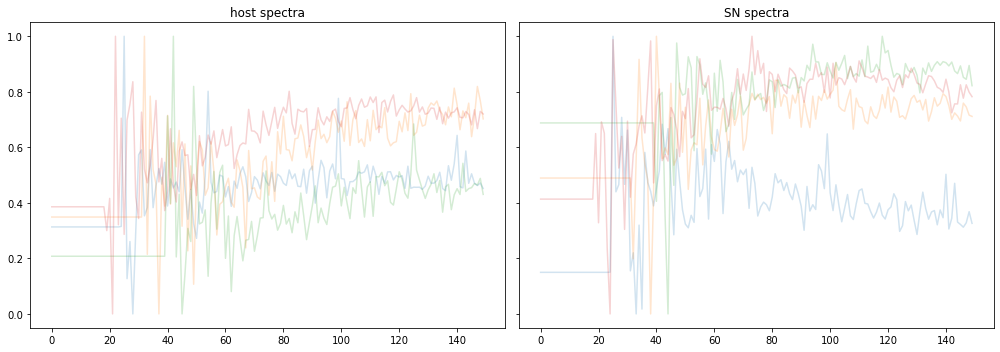

In [42]:
fig, axes = plt.subplots(1,2, figsize=(14,5), sharex=True, sharey=True)

for i in range(0,4):
    
    ax = axes[0]
    ax.plot(host_flux[i], alpha=0.2)

    ax = axes[1]
    ax.plot(snia_flux[i], alpha=0.2)
    
axes[0].set_title('host spectra')
axes[1].set_title('SN spectra')

fig.tight_layout()

In [38]:
nhost, nbins = host_flux.shape
nsnia, nbins = snia_flux.shape
nhost, nsnia, nbins

(9969, 9964, 150)

In [43]:
x = np.concatenate([host_flux, snia_flux]).reshape(-1, nbins, 1)
y = np.concatenate([np.zeros(nhost), np.ones(nsnia)])

In [44]:
import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

/software/python3/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/software/python3/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/software/python3/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/software/python3/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework

In [45]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.layers import (Input, Dense, Activation, ZeroPadding1D, 
BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout,Add, LSTM,Embedding)
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

from tensorflow.keras import utils


#from desispec.interpolation import resample_flux

from tensorflow.keras import backend as K
def network(input_shape, learning_rate=0.0005, reg=0.0032, dropout=0.7436, seed=None):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')
    
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(1, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [46]:
model = network((nbins, 1))

In [47]:
permute = np.random.permutation(len(y))
l = len(x)
hist = model.fit(x[permute][:l], y[permute][:l], batch_size=64, epochs=50, validation_split=0.25, shuffle=True)

Train on 14949 samples, validate on 4984 samples
Epoch 1/50
14949/14949 [==============================] - 10s 638us/step - loss: 1.6918 - acc: 0.5981 - val_loss: 1.4106 - val_acc: 0.6441
Epoch 2/50
14949/14949 [==============================] - 8s 538us/step - loss: 1.2143 - acc: 0.6578 - val_loss: 1.0803 - val_acc: 0.7006
Epoch 3/50
14949/14949 [==============================] - 8s 540us/step - loss: 0.9547 - acc: 0.7181 - val_loss: 0.8644 - val_acc: 0.7346
Epoch 4/50
14949/14949 [==============================] - 8s 533us/step - loss: 0.7941 - acc: 0.7556 - val_loss: 0.7531 - val_acc: 0.7530
Epoch 5/50
14949/14949 [==============================] - 8s 539us/step - loss: 0.7037 - acc: 0.7668 - val_loss: 0.6679 - val_acc: 0.7829
Epoch 6/50
14949/14949 [==============================] - 8s 532us/step - loss: 0.6425 - acc: 0.7808 - val_loss: 0.5925 - val_acc: 0.8012
Epoch 7/50
14949/14949 [==============================] - 8s 541us/step - loss: 0.6027 - acc: 0.7894 - val_loss: 0.5808 - 

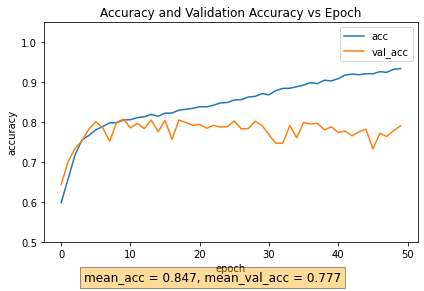

In [48]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
a = np.mean(hist.history['acc'])
v = np.mean(hist.history['val_acc'])
plt.title('Accuracy and Validation Accuracy vs Epoch')
# plt.text(x,y,')
plt.figtext(0.5, 0.01, 'mean_acc = {0:0.3f}, mean_val_acc = {1:0.3f}'.format(a,v), ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.4, "pad":4})
plt.ylabel('accuracy')
plt.ylim([.5,1.05])
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='best')
plt.tight_layout()
plt.show()


# Trying Professor Benzvi's code from cnn_training

In [49]:
idx = np.random.choice(a=len(y), size=int(0.2 * len(y)))
x_test = x[idx]
y_test = y[idx]
y_pred = model.predict(x_test).ravel()

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
pre, rec, _ = precision_recall_curve(y_test, y_pred)


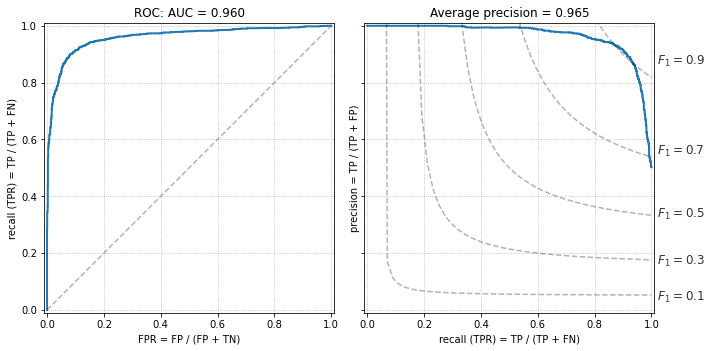

In [50]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

ax = axes[0]
ax.plot(fpr, tpr, lw=2)
ax.plot((0,1), (0,1), 'k--', alpha=0.3)
ax.grid(ls=':')
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(auc(fpr, tpr)),
       aspect='equal')

ax = axes[1]
ax.plot(rec, pre, lw=2)
f_scores = np.linspace(0.1, 0.9, num=5)
lines = []
labels = []
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()


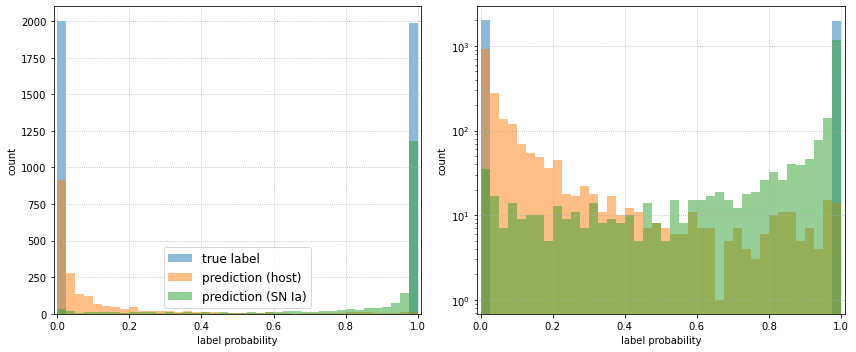

In [51]:
### Confusion Matrix

fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

ax = axes[0]
ybins = np.linspace(0,1,41)
ax.hist(y_test, bins=ybins, alpha=0.5, label='true label')
ax.hist(y_pred[y_test==0], bins=ybins, alpha=0.5, label='prediction (host)')
ax.hist(y_pred[y_test==1], bins=ybins, alpha=0.5, label='prediction (SN Ia)')
ax.grid(ls=':')
ax.set(xlabel='label probability',
       xlim=(-0.01, 1.01),
       ylabel='count')
ax.legend(fontsize=12, loc='best')

ax = axes[1]
ybins = np.linspace(0,1,41)
ax.hist(y_test, bins=ybins, alpha=0.5, label='true label')
ax.hist(y_pred[y_test==0], bins=ybins, alpha=0.5, label='prediction (host)')
ax.hist(y_pred[y_test==1], bins=ybins, alpha=0.5, label='prediction (SN Ia)', log=True)
ax.grid(ls=':')
ax.set(xlabel='label probability',
       xlim=(-0.01, 1.01),
       ylabel='count')

fig.tight_layout()

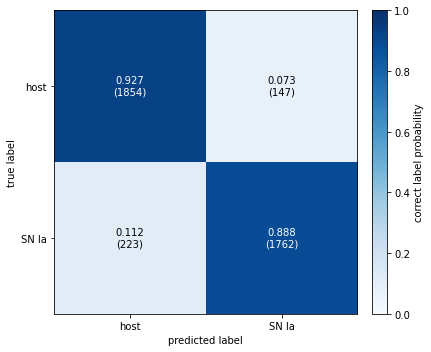

In [52]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred > 0.5)
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(6,5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label probability')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=['host', 'SN Ia'],
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=['host', 'SN Ia'])

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()

model.save('twolabel_cnn')

## Trying what we have bee doing for the ones before this

In [53]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
# Splitting the data 
X = np.concatenate([host_flux, snia_flux]).reshape(-1, nbins, 1)
y = np.concatenate([np.zeros(nhost), np.ones(nsnia)])
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25)

Epoch 1/50
14949/14949 [==============================] - 9s 581us/step - loss: 1.7194 - acc: 0.6016
Epoch 2/50
14949/14949 [==============================] - 7s 499us/step - loss: 1.2603 - acc: 0.6556
Epoch 3/50
14949/14949 [==============================] - 7s 495us/step - loss: 1.0136 - acc: 0.6974
Epoch 4/50
14949/14949 [==============================] - 7s 497us/step - loss: 0.8464 - acc: 0.7405
Epoch 5/50
14949/14949 [==============================] - 7s 499us/step - loss: 0.7366 - acc: 0.7666
Epoch 6/50
14949/14949 [==============================] - 7s 500us/step - loss: 0.6703 - acc: 0.7757
Epoch 7/50
14949/14949 [==============================] - 7s 498us/step - loss: 0.6174 - acc: 0.7930
Epoch 8/50
14949/14949 [==============================] - 7s 500us/step - loss: 0.5861 - acc: 0.7928
Epoch 9/50
14949/14949 [==============================] - 7s 498us/step - loss: 0.5613 - acc: 0.7974
Epoch 10/50
14949/14949 [==============================] - 7s 496us/step - loss: 0.5352 - a

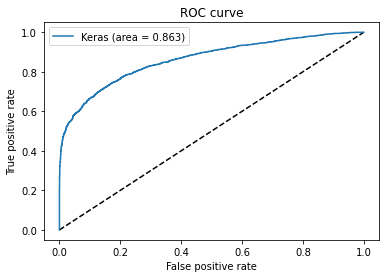

In [54]:
"""Trying from the blog"""
# Classifier
keras_model = network((nbins, 1))
keras_model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)
from sklearn.metrics import roc_curve
y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

# Area under the curve
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


Average precision-recall score: 0.87


Text(0.5, 1.0, 'Precision Recall Curve with average precision of 0.87')

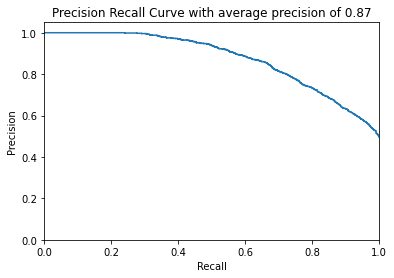

In [234]:
############
import random
import pylab as pl
import numpy as np
from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

"""# The source code uses decision_function
but that is only applicable to sequential class and not the model class that our classifer uses.
Check here for more reference: https://stats.stackexchange.com/questions/329857/what-is-the-difference-between-decision-function-predict-proba-and-predict-fun"""
y_score = keras_model.predict(X_test).ravel() 


# Average precision score
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

#https://scikit-plot.readthedocs.io/en/stable/Quickstart.html
#Used Professor's Benzvi's code for PR curve
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_keras)
plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall Curve with average precision of {0:0.2f}'.format(average_precision))

########

Normalized confusion matrix
Accuracy:  0.7837078651685393


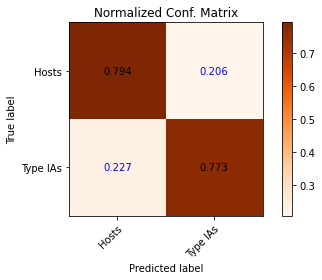

In [55]:
from sklearn.metrics import confusion_matrix

y_pred = y_pred_keras

def plotConfusionMatrix(y_true, y_pred, classes=["Hosts", "Type IAs", "Type IIPs"], cmap=plt.cm.Oranges, title="Normalized Confusion Matrix"):
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred>0.5)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
    #print(cm)
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # create text annotations
    fmt = '.3f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="blue" if cm[i, j] < thresh else "black")
    fig.tight_layout()
    plt.ylim([1.5, -.5])

    plt.show()
    return ax

for i in range(len(y_pred)):
    y_pred[i]=round(y_pred[i])

plotConfusionMatrix(y_true=y_test, y_pred=y_pred, title="Normalized Conf. Matrix")